## Hybrid Precip Distribution

Distribute precipitation at Como Creek based on the reconstructed SWE climatology from Jepsen et al. (2012) and based on published lapse rates durring the summer from Bigler et al. (2007). This is following methods in Livneh et al. (2014) and personal communication with Andrew Badger (Livneh's post-doc).

Maximum snow weight scaled so that annual gridded precipitation matches values published in knowles et al., (2015).

References:

Bigler, C., D. G. Gavin, C. Gunning, and T. T. Veblen (2007),
Drought induces lagged tree mortality in a subalpine forest in the Rocky Mountains, 
Oikos, 116(12), 1983–1994, doi:10.1111/j.2007.0030-1299.16034.x.

Jepsen, S. M., N. P. Molotch, M. W. Williams, K. E. Rittger, and J. O. Sickman (2012), Interannual variability of snowmelt in the Sierra Nevada and Rocky Mountains, United States: Examples from two alpine watersheds, Water Resources Research, 48(2), 1–15, doi:10.1029/2011WR011006.

Knowles, J. F., A. A. Harpold, R. Cowie, M. Zeliff, H. R. Barnard, S. P. Burns, P. D. Blanken, J. F. Morse, and M. W. Williams (2015), The relative contributions of alpine and subalpine ecosystems to the water balance of a mountainous, headwater catchment, Hydrol. Process., 29(22), 4794–4808, doi:10.1002/hyp.10526.

Livneh, B., J. S. Deems, D. Schneider, J. J. Barsugli, and N. P. Molotch (2014), Filling in the gaps: Inferring spatially distributed precipitation from gauge observations over complex terrain, Water Resources Research, 50(11), 8589–8610, doi:10.1002/2014WR015442.

In [1]:
# dates to produce gridded data between
strt = '1990-10-01'
nd = '2013-09-30'

# dates to use the snow scaling map
winter_strt = '10-01'
winter_nd = '05-31'

# maxweight in the raw weights data set is 15.392876
maxweight = 6.35 # maxweight of 10.25 and monthly lapse rates work best to compare with Knowles data, 7 was used to drastically reduce precip.
# 12.25 puts niwot snotel at about a scaled weight of 1.

cellsize=60
c1_weight = 0.108102336525917 # value for the c1 cell in the SWE climatology map (from QGIS)
site_elev = 3018 # met station site elevation in m

# commented out below in deference to the Bigler data
#plapse = 0.00004 # m/m
#tmaxlapse = -1.241379e-02# deg C / m
#tminlapse = -1.103448e-02# deg C / m
#tavelapse = -0.007651# deg C / m

In [2]:
# data frame of lapse rates from Bigler et al. (2007)

months = np.arange(1,13)
temp = [-2.1,-3.3,-5.0,-6.5,-6.2,-5.6,-5.5,-5.6,-5.2,-5.0,-4.5,-2.5] # [degC/km]
precip = [55.1,52.6,64.0,64.2,33.6,17.6,16.0,14.6,17.0,23.2,53.1,42.5] # [mm/km]

lapse = pd.DataFrame({'month':months,'T':temp,'P':precip})
lapse.index = lapse.month

lapse.P /= (1000.*1000.) # [mm/km] > [m/m]
lapse.T = lapse['T'].as_matrix()/1000. # [deg C/km] > [deg C/m]

In [3]:
# crop to the start and end of the gridded data time period
c1 = pd.read_pickle('./data/c1_met_jennings_QAQC_corrP.pcl')[strt:nd]

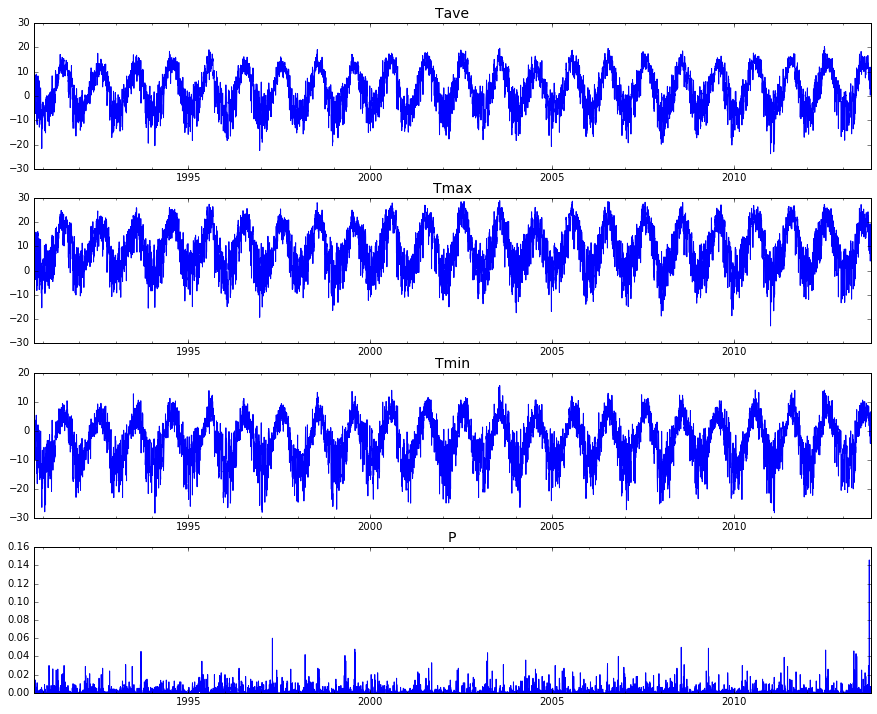

In [4]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

for ax,var in zip([ax1,ax2,ax3,ax4],['Tave','Tmax','Tmin','P']):
    plt.sca(ax)
    c1[var].plot()
    plt.title(var, fontsize=14)
    plt.xlabel('')

In [5]:
import gdal
from mpl_toolkits.basemap import Basemap
shp = '/Volumes/data/como_watershed_wgs84.shp'

def coord2dd(d,m,s): return d+(m/60.)+(s/60.)

import ProgressBar as pb
p = pb.ProgressBar(len(c1))

In [6]:
def load_spatial():
    fl = '/RHESSys/Como/auxdata/gridmet_dem_%sm_crop.tiff'%cellsize
    ds = gdal.Open(fl)
    dem = np.array(ds.GetRasterBand(1).ReadAsArray())

    fl = '/RHESSys/Como/auxdata/gridmet_index_%sm_crop.tiff'%cellsize
    ds = gdal.Open(fl)
    idx = np.array(ds.GetRasterBand(1).ReadAsArray())

    fl = '/RHESSys/Como/auxdata/swe_climatology_jepsen_crop.tiff'
    ds = gdal.Open(fl)
    weights = np.array(ds.GetRasterBand(1).ReadAsArray())/c1_weight
    
    # get reshape parameters
    l,k = dem.shape
    n = l*k
    
    # reshape the rasters all in the same way
    dem.shape = n
    idx.shape = n
    weights.shape = n
    
    return dem,idx,weights,l,k,n

In [7]:
def scaled_weights(maxweight,weights,l,k,save=False):
    # rescale the weights so the maximum is the maximum weight
    scaled = weights.copy()
    scaled[scaled>1] = weights[weights>1]/(weights.max()/maxweight)
    #scaled = weights/(weights.max()/maxweight)
    scaled2 = scaled.copy()
    scaled2.shape = (l,k)
    
    if save:
        np.save('./data/scaled_jepsen_weights_60m.npy',scaled2)
    
    return scaled

In [8]:
def save_gridded_data():
    header = '%s\n%s %s %s 1'%(n,c1.index[0].year,c1.index[0].month, c1.index[0].day)

In [9]:
def grid_data(idx,dem,scaled,n):
    out = pd.DataFrame(np.ndarray((len(c1)+2,n)))
    out.iloc[0,:] = idx # add the index numbers to the data frame
    out.iloc[1,:] = dem # add the dem values to the data frame
    
    # make copies of the data frame for population
    Tmax = out.copy()
    Tmin = out.copy()
    Tave = out.copy()
    P = out.copy()

    elev_diff = dem - site_elev
    winter_strt_month = int(winter_strt.split('-')[0])
    winter_strt_day = int(winter_strt.split('-')[1])
    winter_nd_month = int(winter_nd.split('-')[0])
    winter_nd_day = int(winter_nd.split('-')[1])

    ct = 2 # start at 2 b/c the first 2 rows are full
    for day in c1.index:

        year = int(day.year)
        month = day.month

        # compute the start and end of the winter time period
        winter_strt2 = pd.datetime(year,winter_strt_month,winter_strt_day)
        winter_nd2 = pd.datetime(year,winter_nd_month,winter_nd_day)

        tlapse = lapse.loc[lapse.month==month,'T'].as_matrix()[0] # pull out the temp. lapse rate
        plapse = lapse.loc[lapse.month==month,'P'].as_matrix()[0] # pull out the precip. lapse rate    
        #plapse = 0.000038 # static precip lapse rate m/m, mean from bigler et al.

        Tmax.iloc[ct,:] = c1.loc[day].Tmax + (tlapse*elev_diff)
        Tmin.iloc[ct,:] = c1.loc[day].Tmin + (tlapse*elev_diff)
        Tave.iloc[ct,:] = c1.loc[day].Tave + (tlapse*elev_diff)

        if (day>winter_nd2) & (day<winter_strt2) & (c1.loc[day].P > 0): # test if the day is during the summer
            # distribute summer precip based on published lapse rates
            P.iloc[ct,:] = c1.loc[day].P + (plapse*elev_diff)

            #if c1.loc[day].P > 0:# ensure that there is actually precipitation


        else: #f the day is during winter
            # distribute winter precip based on the Jepsen reconstruction
            P.iloc[ct,:] = c1.loc[day].P * scaled

        ct+=1

    # convert the data frames to numpy arrays
    Tmax = Tmax.as_matrix()
    Tmin = Tmin.as_matrix()
    Tave = Tave.as_matrix()
    P = P.as_matrix()

    P[P<0] = 0. # precip that is for some reason negative should be zeroed
    
    return Tmax,Tmin,Tave,P

In [10]:
def check_data(Tmax,Tmin,Tave,P):
    # re-summarize the data to make sure the gridding is working as expected
    check = pd.DataFrame({'Tmax':np.mean(Tmax[2:,:],axis=1),
                         'Tmin':np.mean(Tmin[2:,:],axis=1),
                         'Tave':np.mean(Tave[2:,:],axis=1),
                         'P':np.mean(P[2:,:],axis=1)},index = c1.index)
    check['wateryear'] = check.index.map(rut.wateryear)
    return check

In [11]:
def comparison(check):
    comp = pd.DataFrame(check.groupby(by='wateryear').sum()['P']*1000)
    comp.columns=['distribution']
    comp = comp.loc[(comp.index>=2008) & (comp.index < 2013)].copy()
    comp['knowles'] = [955,841,855,1198,800]
    comp['scale'] = comp.knowles/comp.distribution
    comp['diff'] = comp.knowles-comp.distribution
    
    diff = comp['diff'].as_matrix()
    
    rmse = np.sqrt(np.mean(np.square(diff)))
    
    return rmse

In [12]:
def run(maxweight):
    dem,idx,weights,l,k,n=load_spatial()
    scaled = scaled_weights(maxweight,weights,l,k,save=False)
    Tmax,Tmin,Tave,P = grid_data(idx,dem,scaled,n)
    check = check_data(Tmax,Tmin,Tave,P)
    rmse = comparison(check)
    
    return rmse,check

## Loop through some maximum weights and look at the RMSE

In [28]:
maxweights = np.arange(10.4,10.6,0.01)

In [29]:
rmses = []
checks = []
for maxweight in maxweights:
    rmse,check = run(maxweight)
    rmses.append(rmse)
    checks.append(check)
    
res = pd.DataFrame({'rmse':rmses,'maxweight':maxweights,'check':checks})

In [30]:
res.to_pickle('./data/precip_maxweight_seasonal_lapse4.pcl')

## Note:
file precip_maxweight_seasonal_lapse4.pcl has the lowest RMSE, a larger range of points was searched using files 2 and 3 as well.

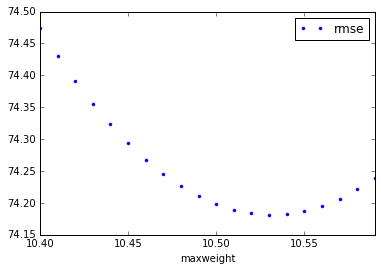

In [31]:
res.plot('maxweight','rmse',marker='.', lw=0)

(74, 75)

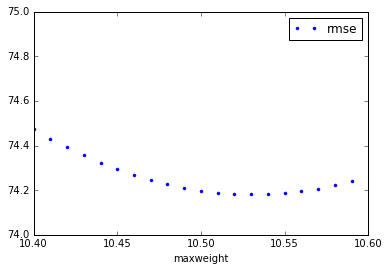

In [34]:
res.plot('maxweight','rmse',marker='.', lw=0)
plt.xlim(10.4,10.6)
plt.ylim(74,75)

In [35]:
res.loc[res.rmse==res.rmse.min()]

,check,maxweight,rmse
13,P Tave Tmax ...,10.53,74.181492


In [60]:
# load the last few results data frames:

dat = pd.read_pickle('./data/precip_maxweight_seasonal_lapse2.pcl')
dat = dat.append(pd.read_pickle('./data/precip_maxweight_seasonal_lapse3.pcl'))
dat = dat.append(pd.read_pickle('./data/precip_maxweight_seasonal_lapse4.pcl'))
dat.reset_index(inplace=True)

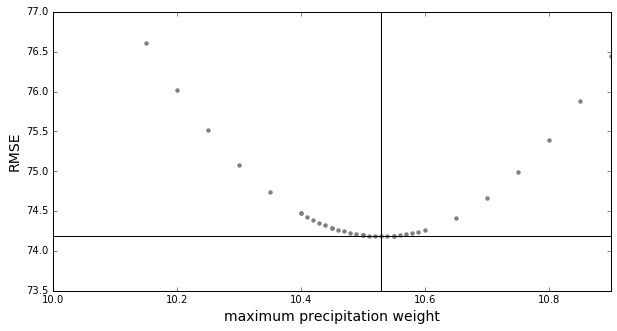

In [64]:
dat.plot.scatter('maxweight','rmse',s=20, c='0.5',lw=0, legend=False,figsize=(10,5))
plt.xlim(10,10.9)
plt.ylim(73.5,77)
plt.xlabel('maximum precipitation weight', fontsize = 14)
plt.ylabel('RMSE', fontsize = 14)
plt.axhline(dat['rmse'][dat.rmse.idxmin()],color='k')
plt.axvline(dat['maxweight'][dat.rmse.idxmin()],color='k')
plt.savefig('./figures/gridded_precip_optimization.png',dpi=300,bbox_inches='tight')

In [59]:
dat['rmse'][dat.rmse.idxmin()]

13    212.310289
13     76.606843
13     74.181492
Name: rmse, dtype: float64

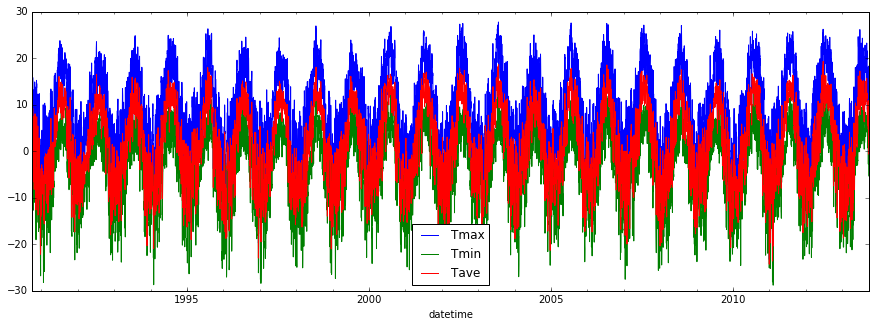

In [48]:
check[['Tmax','Tmin','Tave']].plot(figsize=(15,5))

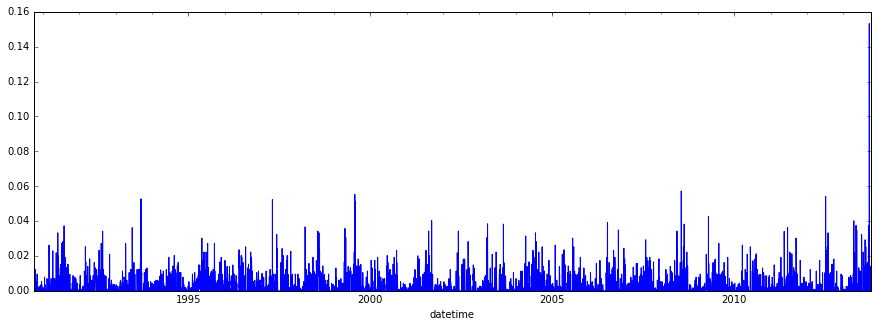

In [49]:
check.P.plot(figsize=(15,5))

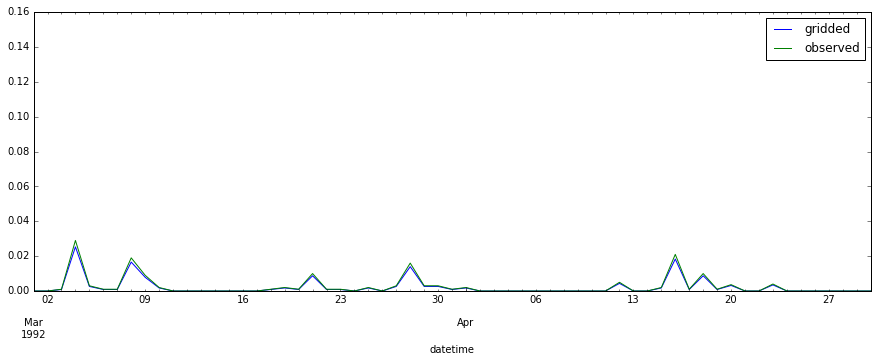

In [218]:
check.P.plot(figsize=(15,5),label='gridded')
c1.P.plot(label='observed')
plt.xlim('1992-3-1','1992-4-30')
plt.legend()

In [220]:
np.savetxt('/RHESSys/Como/clim/grid%s.tmax'%(cellsize),Tmax,header=header,comments='',fmt='%3.2f')
np.savetxt('/RHESSys/Como/clim/grid%s.tmin'%(cellsize),Tmin,header=header,comments='',fmt='%3.2f')
np.savetxt('/RHESSys/Como/clim/grid%s.tavg'%(cellsize),Tave,header=header,comments='',fmt='%3.2f')
np.savetxt('/RHESSys/Como/clim/grid%s.rain'%(cellsize),P,header=header,comments='',fmt='%3.6f')

## Generate a single grid cell data set for calibration

In [34]:
columns = Tmax[0,:]
idx = np.where(columns==4723)[0][0] # index value of the snotel gridcell

In [35]:
np.savetxt('/RHESSys/Como/clim/grid%s_niwotsnotel.tmax'%(cellsize),Tmax[:,idx],header=header,comments='',fmt='%3.2f')
np.savetxt('/RHESSys/Como/clim/grid%s_niwotsnotel.tmin'%(cellsize),Tmin[:,idx],header=header,comments='',fmt='%3.2f')
np.savetxt('/RHESSys/Como/clim/grid%s_niwotsnotel.tavg'%(cellsize),Tave[:,idx],header=header,comments='',fmt='%3.2f')
np.savetxt('/RHESSys/Como/clim/grid%s_niwotsnotel.rain'%(cellsize),P[:,idx],header=header,comments='',fmt='%3.6f')

In [36]:
weights[idx]

1.2923023

In [37]:
scaled[idx]

0.86053437

## Remove extra cells around Como Creek Watershed

In [38]:
import gdal

In [39]:
fl = '/RHESSys/Como/auxdata/grid60_como.tiff'
ds = gdal.Open(fl,gdal.GA_ReadOnly)
rast = np.array(ds.GetRasterBand(1).ReadAsArray(),dtype=np.float32)
rast[rast==65535] = np.NaN
cells = np.unique(rast[np.isnan(rast)==False])

In [40]:
idx = []

for cell in cells:
    idx.append(np.where(columns==cell)[0][0])

In [47]:
header = '%s\n%s %s %s 1'%(len(cells),c1.index[0].year,c1.index[0].month, c1.index[0].day)

In [48]:
np.savetxt('/RHESSys/Como/clim/grid%s_sm.tmax'%(cellsize),Tmax[:,idx],header=header,comments='',fmt='%3.2f')
np.savetxt('/RHESSys/Como/clim/grid%s_sm.tmin'%(cellsize),Tmin[:,idx],header=header,comments='',fmt='%3.2f')
np.savetxt('/RHESSys/Como/clim/grid%s_sm.tavg'%(cellsize),Tave[:,idx],header=header,comments='',fmt='%3.2f')
np.savetxt('/RHESSys/Como/clim/grid%s_sm.rain'%(cellsize),P[:,idx],header=header,comments='',fmt='%3.6f')

In [49]:
print header

1472
1990 10 1 1
